# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек и функций

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
#базовые
import pandas as pd
import numpy as np
from scipy import stats as st
# графики
import seaborn as sns
import matplotlib.pyplot as plt
#анализ корреляции Phi_K 
!pip install phik -q
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# преобразование данных
from sklearn.model_selection import train_test_split, cross_val_score
# Модели
from sklearn.linear_model import LinearRegression
# Метрики
from sklearn.metrics import mean_squared_error, root_mean_squared_error

RANDOM_STATE = 88

In [3]:
#функция первичного анализа данных
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if (temp[temp[column] == 0][column].count() > 0) | (
            temp[temp[column] == ' '][column].count() > 0):
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пустыми и нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пустыми и нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if (temp[temp[column] == 0][column].count() > 0) | (
               temp[temp[column] == ' '][column].count() > 0):
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count():<25}'
                      f'{temp[temp[column] == 0][column].count()/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[column].isna().sum() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('='* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('='* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)
#Поиск неявных дубликатов
    string_columns = temp.select_dtypes(include='object').columns.tolist()
    print('Уникальные значения в тестовых полях')
    print('='* 90)
    for column in string_columns:
        values = temp[column].unique()
        if len(values) <= 25:
            print(f'{column}: {values}')
            print('-'* 90)
        else:
            print(f'В поле {column} слишком много значений')
            print('-'* 90)

In [4]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

In [5]:
#матрица корреляции phi_k
def phik_corr(df):
    size = len(df.columns) + 1
    phik_overview = phik_matrix(df)
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(size, size)
    )

### Загрузка и предобработка данных

In [6]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv', index_col = 'id')
region_2 = pd.read_csv('/datasets/geo_data_1.csv', index_col = 'id')
region_3 = pd.read_csv('/datasets/geo_data_2.csv', index_col = 'id')

In [7]:
data_report(region_1)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 1
------------------------------------------------------------------------------------------
Перечень столбцов с пустыми и нулевыми значениями:
---------------------------------------------
Имя поля                                Кол-во значений          Процент к общему         
------------------------------------------------------------------------------------------
product                                 1                        0.00%
------------------------------------

Проверим поле id на наличие неявных дубликатов:

In [8]:
duplicates = region_1[region_1.index.duplicated() == True].index
duplicates.shape

(10,)

Дубликатов всего 20 штук, что составляет ничтожную долю от общего объема данных, поэтому мы можем их удалить без снижения качества прогнозирования.

In [9]:
region_1 = region_1.drop(duplicates, axis=0)
region_1.shape

(99980, 4)

In [10]:
data_report(region_2)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 1
------------------------------------------------------------------------------------------
Перечень столбцов с пустыми и нулевыми значениями:
---------------------------------------------
Имя поля                                Кол-во значений          Процент к общему         
------------------------------------------------------------------------------------------
product                                 8235                     8.24%
------------------------------------

Выполним для этого датасета аналогичную проверку и сброс неявных дубликатов в поле id:

In [11]:
duplicates = region_2[region_2.index.duplicated() == True].index
duplicates.shape

(4,)

Дубликатов всего 8 штук, что составляет ничтожную долю от общего объема данных, поэтому мы можем их удалить без снижения качества прогнозирования.

In [12]:
region_2 = region_2.drop(duplicates, axis=0)
region_2.shape

(99992, 4)

In [13]:
data_report(region_3)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 1
------------------------------------------------------------------------------------------
Перечень столбцов с пустыми и нулевыми значениями:
---------------------------------------------
Имя поля                                Кол-во значений          Процент к общему         
------------------------------------------------------------------------------------------
product                                 1                        0.00%
------------------------------------

Выполним для этого датасета проверку неявных дубликатов в поле id:

In [14]:
duplicates = region_3[region_3.index.duplicated() == True].index
duplicates.shape

(4,)

Дубликатов всего 8 штук, что составляет ничтожную долю от общего объема данных, поэтому мы можем их удалить без снижения качества прогнозирования.

In [15]:
region_3 = region_3.drop(duplicates, axis=0)
region_3.shape

(99992, 4)

### Исследовательский анализ данных

#### Регион 1

Статистический анализ показателя f0
--------------------------------------------------------------------------------------------------------------


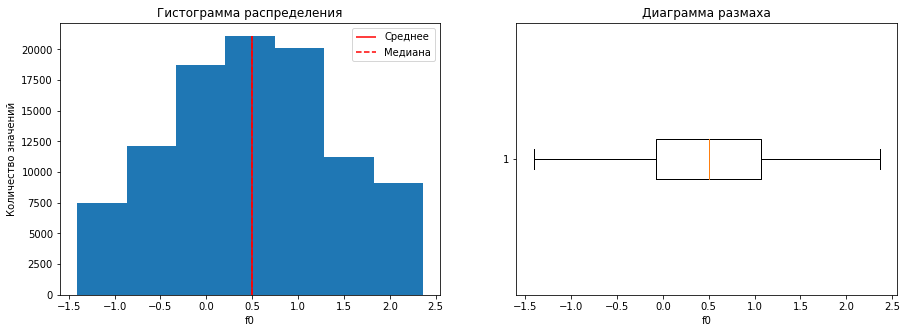

Статистический анализ показателя f1
--------------------------------------------------------------------------------------------------------------


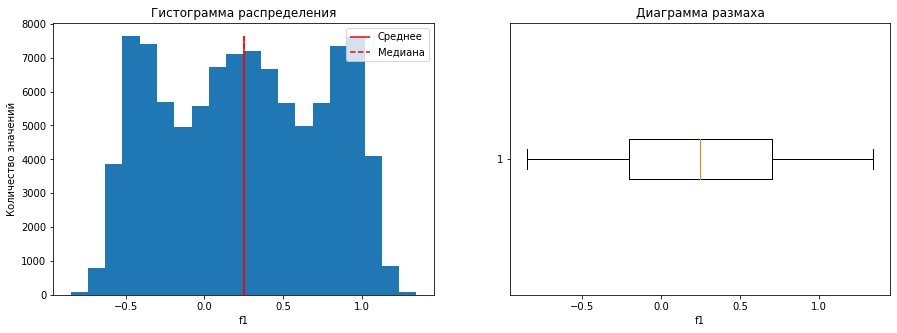

Статистический анализ показателя f2
--------------------------------------------------------------------------------------------------------------


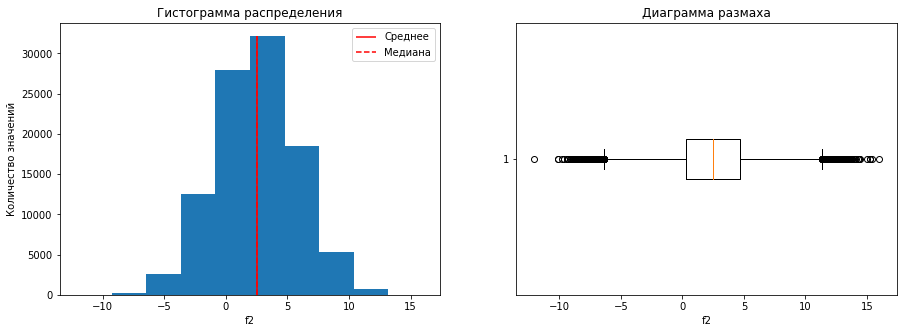

Статистический анализ показателя product
--------------------------------------------------------------------------------------------------------------


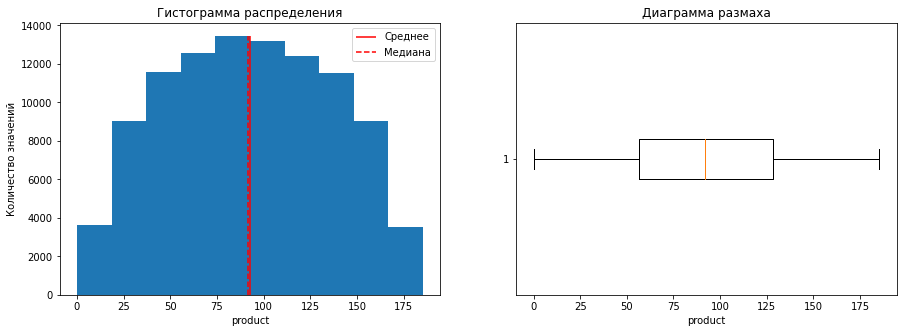

In [16]:
stat_plots(region_1, custom_bins={
    'f0': 7,
    'f1': 20
})

#### Регион 2

Статистический анализ показателя f0
--------------------------------------------------------------------------------------------------------------


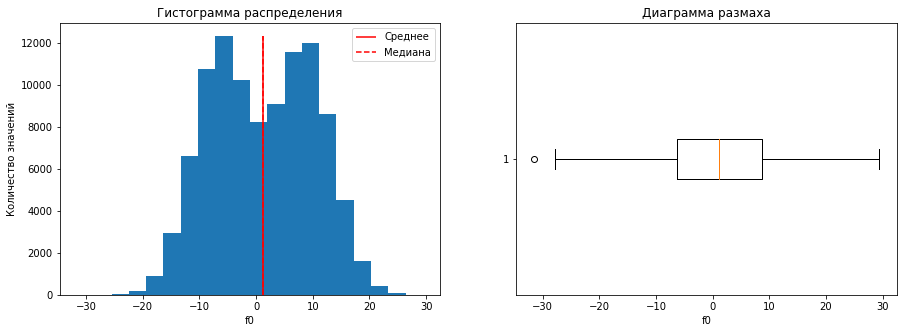

Статистический анализ показателя f1
--------------------------------------------------------------------------------------------------------------


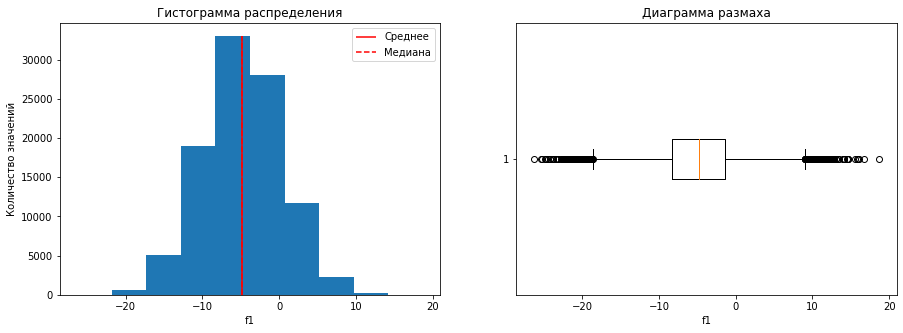

Статистический анализ показателя f2
--------------------------------------------------------------------------------------------------------------


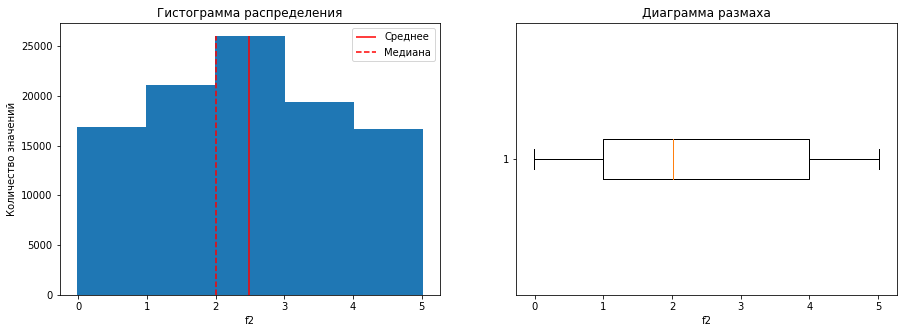

Статистический анализ показателя product
--------------------------------------------------------------------------------------------------------------


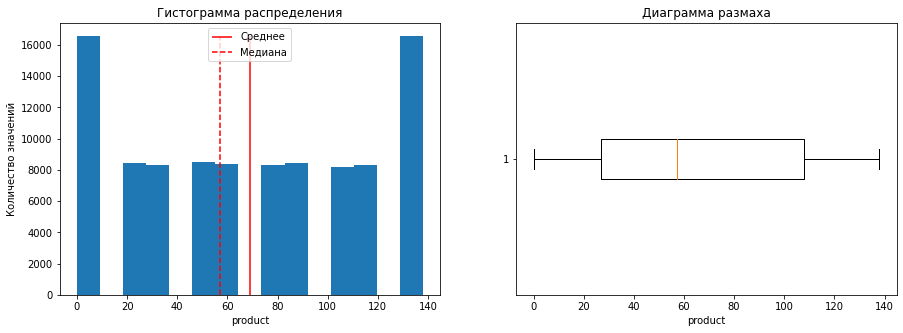

In [17]:
stat_plots(
    region_2,
    custom_bins={
        'f0': 20,
        'f2': 5,
        'product':15
    }
)

#### Регион 3

Статистический анализ показателя f0
--------------------------------------------------------------------------------------------------------------


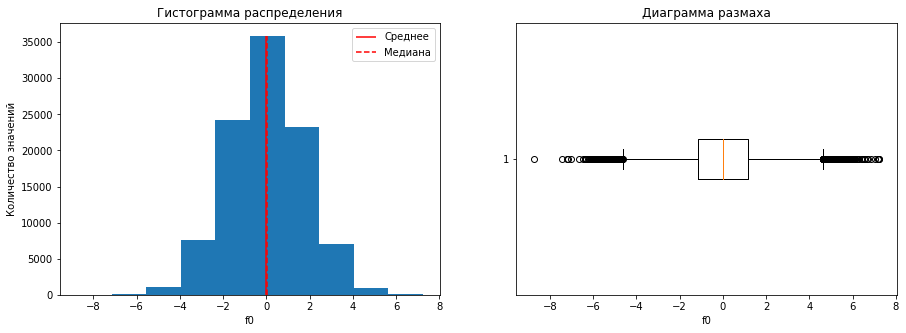

Статистический анализ показателя f1
--------------------------------------------------------------------------------------------------------------


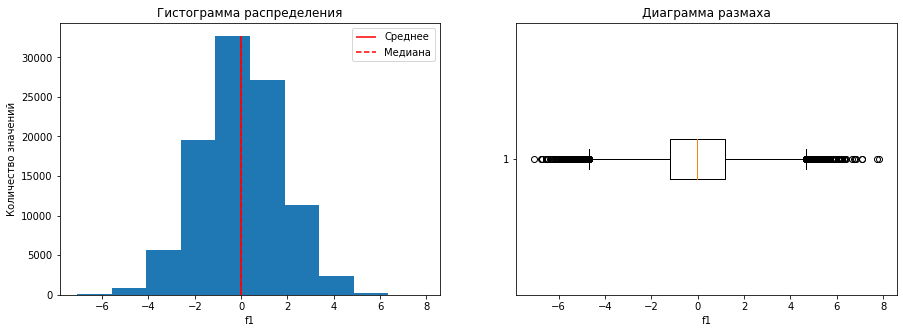

Статистический анализ показателя f2
--------------------------------------------------------------------------------------------------------------


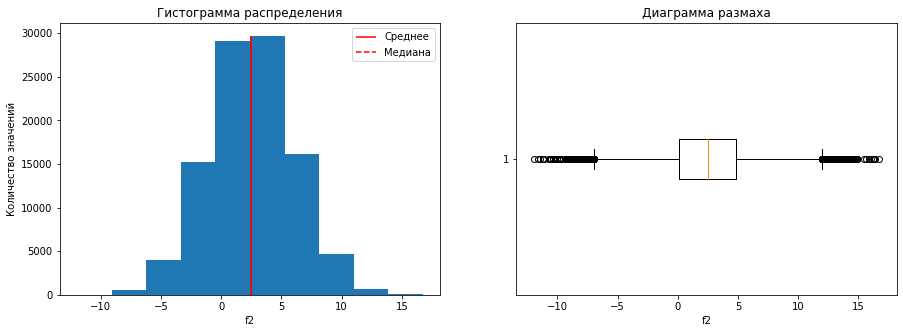

Статистический анализ показателя product
--------------------------------------------------------------------------------------------------------------


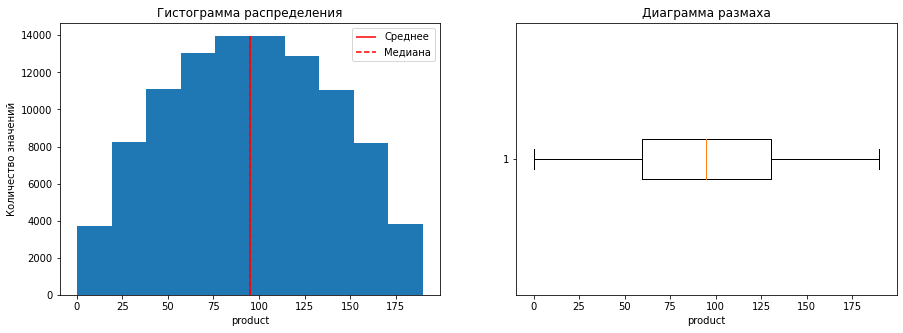

In [18]:
stat_plots(region_3)

### Анализ корреляций

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


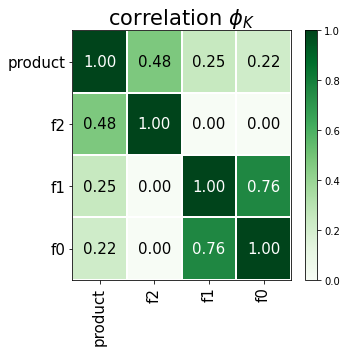

In [19]:
phik_corr(region_1)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


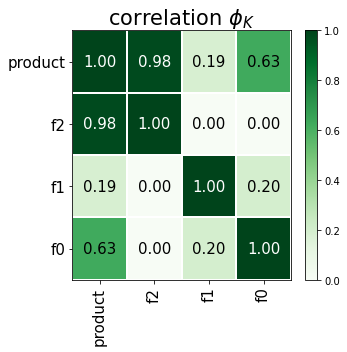

In [20]:
phik_corr(region_2)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


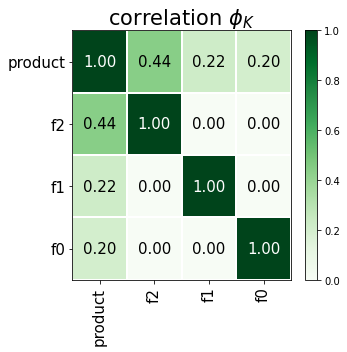

In [21]:
phik_corr(region_3)

### Промежуточный вывод

Исходные данные в порядке, предобработка не требуется.\
Распределение признаков в датасетах Регионов 1 и 3 похожее, и отличается от Региона 2.\
Целевой признак в Регионе 2 дискретный и имеет ненормальное распределение.\
Во всех датасетах имелись ненормально распределенные признаки, поэтому мы использовали методику Phi_K для оценки корреляции.\
Корреляционный анализ показал наличие умеренной корреляции входных признаков с целевым в регионах 1 и 3.\
В регионе 2 прослеживается весьма высокая корреляция входного признака f2 с целевым. 

## Обучение и проверка модели

Определим функцию для оперативного разделения данных на выборки по заданным параметрам

In [22]:
def split(dataset, target_col, test_size):
    X = dataset.drop(target_col, axis=1)
    y = dataset[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

Подготовим данные и модель для обучения

In [23]:
dataset = [region_1, region_2, region_3]
model = LinearRegression()
rmse = []
test_preds = []
output_preds = []
output_facts = []
region_capacity = []

Обучим модель и получим предсказания в цикле по всем регионам

In [24]:
for region in dataset:
    X_train, X_test, y_train, y_test = split(region, 'product', 0.25)
    #обучим модель и вычислим ее показатели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    region_capacity.append(int(y_pred.mean() / 1000))
    rmse.append(round(root_mean_squared_error(y_test, y_pred), 2))
    #вычислим и сохраним предсказания для дальнейшей обработки техникой bootstrap
    output_preds.append(pd.Series(y_pred, index=y_test.index))
    #сохраним фактические значения запасов для дальнейшей обработки техникой bootstrap
    output_facts.append(y_test)

Сведем результаты в таблицу и выведем на экран

In [25]:
model_results = pd.DataFrame(
    [region_capacity, rmse],
    index=['Средний предсказанный объем запасов на скважину (млн. баррелей)',
           'Ошибка RMSE обученной модели на тестовых данных'],
    columns=['Регион 1', 'Регион 2', 'Регион 3']
)
model_results

,Регион 1,Регион 2,Регион 3
Средний предсказанный объем запасов на скважину (млн. баррелей),0.00,0.00,0.00
Ошибка RMSE обученной модели на тестовых данных,37.43,0.89,40.03


### Промежуточный вывод

Предсказания по регионам 1 и 3 показали очень низкий уровень точности, в то время как для региона 2 уровень точности чрезвычайно высок. Похоже, это объясняется весьма высокой корреляцией целевого признака с одним из входных, которую мы зафиксировали на этапе корреляционного анализа.

## Подготовка к расчёту прибыли

### Достаточный объём сырья

Объявим константы для всех фиксированных бизнес-показателей. 

In [26]:
BUDGET = 10000
BEST_WELLS_NUMBER = 200
UNIT_PRICE = 0.45
TARGET_OUTPUT = round(BUDGET / BEST_WELLS_NUMBER / UNIT_PRICE, 2)

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и равним его со средним запасом в каждом регионе. 

In [27]:
opt_reg1 = int(np.mean(region_1['product']))
opt_reg2 = int(np.mean(region_2['product']))
opt_reg3 = int(np.mean(region_3['product']))

mean_outputs = pd.DataFrame({'Регион': [1, 2, 3]})
mean_outputs['Средний объем добычи со скважины (тыс. бар.)'] = [opt_reg1, opt_reg2, opt_reg3]
mean_outputs['План добычи (тыс. бар.)'] = TARGET_OUTPUT
mean_outputs['Разница (тыс. бар.)'] = \
    mean_outputs['Средний объем добычи со скважины (тыс. бар.)'] - mean_outputs['План добычи (тыс. бар.)']
mean_outputs

,Регион,Средний объем добычи со скважины (тыс. бар.),План добычи (тыс. бар.),Разница (тыс. бар.)
0,1,92,111.11,-19.11
1,2,68,111.11,-43.11
2,3,94,111.11,-17.11


### Выводы

Случайный выбор скважин для разработки не обеспечит безубыточности.

## Расчёт прибыли и рисков 

### Функция расчета прибыли

In [28]:
def calc_profit(preds_sample, fact_data):
    sample_best_preds = preds_sample.sort_values(ascending=False)[:BEST_WELLS_NUMBER]
    sample_fact_revenue = (fact_data[sample_best_preds.index] * UNIT_PRICE).sum()
    sample_profit = sample_fact_revenue - BUDGET
    return sample_profit

### Расчет прогноза прибыльности по регионам

Применим методику bootstrap для расчета вероятности выхода на показатели безубыточности по регионам

In [29]:
results_mean = []
results_ci = []
profit_distr = []
risk = []

#выполним цикл по регионам
for region in range(len(output_preds)):
    region_data = output_preds[region]
    fact_output = output_facts[region]
    state = np.random.RandomState(12345)
    loss_count = 0
    bootstrap_profit = []
    #для каждого региона выполним расчет вариантов прибыльности методом bootstrap
    for i in range(1000):
        subsample = region_data.sample(n=500, replace=True, random_state=state)
        #вычислим прибыль при помощи ранее определенной функции
        profit = calc_profit(subsample, fact_output)
        bootstrap_profit.append(profit)
    #запишем распределение прибыльности по регионам
    profit_distr.append(bootstrap_profit)
    #вычислим результаты для каждого региона       
    bootstrap_profit = pd.Series(bootstrap_profit)
    results_mean.append(int(bootstrap_profit.mean()))
    ci = []
    ci.append(int(bootstrap_profit.quantile(0.025)))
    ci.append(int(bootstrap_profit.quantile(0.975)))
    results_ci.append(ci)
    risk.append((bootstrap_profit < 0).mean() * 100)

Соберем результаты в общую таблицу и выведем ее на экран

In [30]:
results = pd.DataFrame(
    {'Средняя прибыль (млн.р.)': results_mean,
     '95% доверительный интервал (млн.р.)': results_ci,
    'Риск убыточности добычи (%)': risk},
    index=['Регион 1', 'Регион 2', 'Регион 3']
)
#округлим данные доверительного интервала
results['95% доверительный интервал (млн.р.)'] = results['95% доверительный интервал (млн.р.)'].apply(lambda x: np.round(x, 0))
results

,Средняя прибыль (млн.р.),95% доверительный интервал (млн.р.),Риск убыточности добычи (%)
Регион 1,447,"[-70, 943]",4.7
Регион 2,450,"[37, 856]",1.6
Регион 3,414,"[-117, 937]",6.3


Визуализируем распределение прогнозов прибыльности добычи по регионам

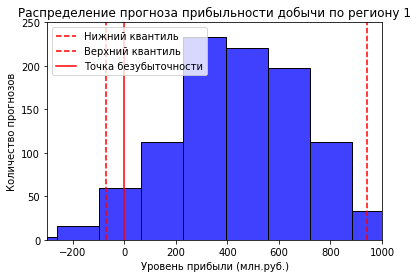

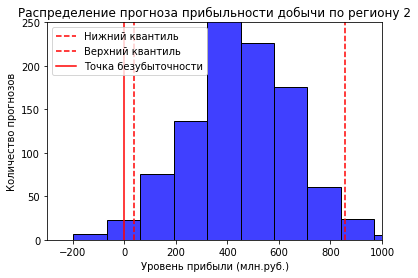

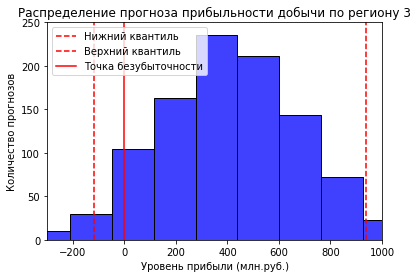

In [31]:
for nreg in range(1, 4):
    reg = profit_distr[nreg-1]
    ci_l = results.iloc[nreg-1, 1][0]
    ci_h = results.iloc[nreg-1, 1][1]

    sns.histplot(data=reg, color='blue', bins=10)
    plt.axvline(x=ci_l, color='red', label='Нижний квантиль', linestyle='--')
    plt.axvline(x=ci_h, color='red', label='Верхний квантиль', linestyle='--')
    plt.axvline(x=0, color='red', label='Точка безубыточности', linestyle='-')
    plt.legend(loc='upper left')
    plt.axis([-300, 1000, 0, 250])
    plt.title(f'Распределение прогноза прибыльности добычи по региону {nreg}')
    plt.xlabel('Уровень прибыли (млн.руб.)')
    plt.ylabel('Количество прогнозов')
    plt.show()

## Итоговый вывод

При работе над проектом мы использовали данные о пробах нефти в трёх регионах по 10 000 месторождений в каждом.\
Целью работы было - при помощи машинного обучения определить регион, где добыча принесёт наибольшую прибыль с минимальным уровнем риска.

Исходные данные содержали 36 дублированных идентификаторов скважин, которые были исключены из анализа в силу их малочисленности.

Исследовательский анализ данных показал схожесть картины распределения признаков в датасетах Регионов 1 и 3 похожее, в отличие  от Региона 2. Во всех датасетах имелись ненормально распределенные признаки, включая целевой признак в Регионе 2.\
Корреляционный анализ методикой Phi_K показал наличие умеренной корреляции входных признаков с целевым в регионах 1 и 3.
В регионе 2 отмечена весьма высокая корреляция входного признака f2 с целевым.

Для формирования предсказаний была обучена модель линейной регрессии, оценка качества модели на тестовых данных производилась метрикой RMSE.\
По результатам обучения, модели показали следующие значения RMSE по регионам:
- Регион 1 - 37.43 тыс. баррелей
- Регион 2 - 0.89 тыс. баррелей
- Регион 3 - 40.03 тыс. баррелей

Для анализа возможной прибыли и рисков разработки скважин в регионах была применена техника Bootstrap на 1000 случайных выборок по 500 скважин из каждого региона. Результаты показали следующее:
- самая высокая средняя прибыльность прогнозируется в регионе 2
- самый низкий риск убыточной разработки скважин также зарегистрирован для региона 2
- риск убытка по региону 2 находится в пределах допустимого согласно требованиям бизнеса

**Рекомендации бизнесу**\
По результатам проведенного моделирования и анализа можно рекомендовать для разработки Регион №2 как регион с наибольшей прогнозируемой прибыльностью, высоким качеством прогнозирования, и приемлемым согласно требованиям риском убытков в размере 1,6 %.